<a href="https://colab.research.google.com/github/2025-02-FML-team/WV-Team/blob/data_augment/05-2_model_build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Argumentation

### Method 1

In [26]:
import os
import shutil
from pathlib import Path

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_DIR = Path('/content/unpacked/')
    PACK_DIR = Path('/content/drive/My Drive/colab_drive/prepacked.zip')
    shutil.copy(PACK_DIR, '/content/')
    !unzip -o -q /content/prepacked.zip -d {DATA_DIR}
else:
    DATA_DIR= Path(os.path.join(os.getcwd(), "../data/")).resolve()
DATA_DIR

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


PosixPath('/content/unpacked')

In [27]:
import re
import glob
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm

# CSV 로드 및 정리, 본인 경로에 맞게 변환
CSV_PATH = DATA_DIR / 'whiskies_recategorized.csv'
IMAGE_SIZE = (128, 128)
RANDOM_STATE = 42

둘중하나만 실행 아래거는 Rye삭제 sm40,43통합

In [28]:
df = pd.read_csv(CSV_PATH, dtype={"id": str})
df["id"] = df["id"].astype(str).str.strip().str.replace(r"\.0$", "", regex=True)
df["category"] = df["category"].astype(str).str.strip()
paths = [DATA_DIR / p for p in df["local_full_path"]]

bar = tqdm(paths, desc="Processing Images", unit="img")

# 이미지 로드
X_list = []
for p in bar:
    with Image.open(p) as im:
        im = im.convert("RGB")
        im = im.resize(IMAGE_SIZE)
        arr = np.asarray(im, dtype=np.uint8)
        X_list.append(arr)
X = np.stack(X_list, axis=0)

Processing Images:   0%|          | 0/2942 [00:00<?, ?img/s]

In [ ]:
df = pd.read_csv(CSV_PATH, dtype={"id": str})
df["id"] = df["id"].astype(str).str.strip().str.replace(r"\.0$", "", regex=True)
df["category"] = df["category"].astype(str).str.strip()

# ---------------------------------------------------
# 🔥 1) Rye 삭제
df = df[df["category"] != "Rye"]

# 🔥 2) SM_40_43 + SM_43_46 → SM_40_46 병합
df["category"] = df["category"].replace({
    "SM_40_43": "SM_40_46",
    "SM_43_46": "SM_40_46"
})
# ---------------------------------------------------

# 이미지 경로 세팅
paths = [DATA_DIR / p for p in df["local_full_path"]]

bar = tqdm(paths, desc="Processing Images", unit="img")

# 이미지 로드
X_list = []
for p in bar:
    with Image.open(p) as im:
        im = im.convert("RGB")
        im = im.resize(IMAGE_SIZE)
        arr = np.asarray(im, dtype=np.uint8)
        X_list.append(arr)
X = np.stack(X_list, axis=0)

Processing Images:   0%|          | 0/2867 [00:00<?, ?img/s]

------------------------------

둘중하나 선택 아래거는 validatoin으로도 나눔 72:18:10

In [29]:
# 라벨 인코딩
labels = df["category"].values
le = LabelEncoder()
y_int = le.fit_transform(labels)

# train/test 분리
train_images, test_images, train_labels, test_labels = train_test_split(
    X, y_int, test_size=0.2, random_state=RANDOM_STATE, stratify=y_int
)

print("train_images:", train_images.shape)
print("test_images:", test_images.shape)
print("train_labels 분포:", np.bincount(train_labels))
print("test_labels 분포:", np.bincount(test_labels))
print("class mapping:", dict(zip(le.classes_, range(len(le.classes_)))))

train_images: (2353, 128, 128, 3)
test_images: (589, 128, 128, 3)
train_labels 분포: [414 208 122 104 114 110  62 185 205 640  67 122]
test_labels 분포: [104  52  31  26  29  27  15  47  51 160  17  30]
class mapping: {'Blended': 0, 'Bourbon': 1, 'Brandy': 2, 'Gin': 3, 'Liqueur': 4, 'Rum': 5, 'Rye': 6, 'SM_40_43': 7, 'SM_43_46': 8, 'SM_G46': 9, 'Tequila': 10, 'Vodka': 11}


In [40]:
from sklearn.model_selection import train_test_split

# 1) 원래 train/test 분리
train_images, test_images, train_labels, test_labels = train_test_split(
    X, y_int, test_size=0.1, random_state=RANDOM_STATE, stratify=y_int
)

# 2) train → train/validation 재분리 (train의 20%를 val로)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=0.2,   # train의 20% = 전체의 16% 정도가 validation으로 가게 됨
    random_state=RANDOM_STATE,
    stratify=train_labels
)

print("train_images:", train_images.shape)
print("val_images:", val_images.shape)
print("test_images:", test_images.shape)

print("train_labels 분포:", np.bincount(train_labels))
print("val_labels 분포:", np.bincount(val_labels))
print("test_labels 분포:", np.bincount(test_labels))

train_images: (2117, 128, 128, 3)
val_images: (530, 128, 128, 3)
test_images: (295, 128, 128, 3)
train_labels 분포: [373 187 110  94 103  98  55 167 184 576  60 110]
val_labels 분포: [ 93  47  28  23  26  25  14  42  46 144  15  27]
test_labels 분포: [52 26 15 13 14 14  8 23 26 80  9 15]


--------------------

데이터 증강1

In [5]:
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 클래스별 개수 확인
counter = Counter(train_labels)
print("Before augmentation:", counter)

# 증강용 데이터 제너레이터 설정
datagen = ImageDataGenerator(
    rotation_range=20,       # 20도까지 회전
    horizontal_flip=True,    # 좌우 반전
    width_shift_range=0.1,   # 좌우 이동
    height_shift_range=0.1,  # 상하 이동
    zoom_range=0.1           # 약간의 확대/축소
)

target_count = max(counter.values())  # 가장 많은 클래스 수

aug_images = []
aug_labels = []

for cls, count in counter.items():
    cls_indices = np.where(train_labels == cls)[0]
    n_needed = target_count - count

    if n_needed > 0:
        for i in range(n_needed):
            idx = np.random.choice(cls_indices)
            img = train_images[idx]
            img = np.expand_dims(img, 0)  # ImageDataGenerator는 4D 입력 필요

            # 증강 이미지 한 장 생성
            for batch in datagen.flow(img, batch_size=1):
                aug_img = batch[0].astype(np.uint8)
                aug_images.append(aug_img)
                aug_labels.append(cls)
                break  # 1장만 생성

# 기존 데이터와 합치기
if aug_images:
    train_images = np.concatenate([train_images, np.array(aug_images)], axis=0)
    train_labels = np.concatenate([train_labels, np.array(aug_labels)], axis=0)

# 확인
counter_after = Counter(train_labels)
print("After augmentation:", counter_after)

Before augmentation: Counter({np.int64(9): 640, np.int64(0): 414, np.int64(1): 208, np.int64(8): 205, np.int64(7): 185, np.int64(2): 122, np.int64(11): 122, np.int64(4): 114, np.int64(5): 110, np.int64(3): 104, np.int64(10): 67, np.int64(6): 62})
After augmentation: Counter({np.int64(9): 640, np.int64(1): 640, np.int64(0): 640, np.int64(4): 640, np.int64(6): 640, np.int64(2): 640, np.int64(7): 640, np.int64(5): 640, np.int64(3): 640, np.int64(8): 640, np.int64(11): 640, np.int64(10): 640})


데이터증강2

In [17]:
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 재현성
np.random.seed(RANDOM_STATE)

# 현재 분포 확인
counter = Counter(train_labels)
print("Before augmentation:", counter)

# 증강 설정 (필요하면 파라미터 조정)
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'   # 변형 후 빈 픽셀 처리
)

aug_images = []
aug_labels = []

# 각 클래스별로 목표 배수(3배/2배) 계산 후 부족한 수만큼 생성
for cls, count in counter.items():
    if count < 100:
        mult = 4
    if count < 150:
        mult = 3
    elif count < 300:
        mult = 2
    else:
        # 300 이상이면 증강하지 않음
        continue

    target = int(count * mult)
    n_needed = target - count
    print(f"Class {cls}: count={count}, target={target}, need aug={n_needed}")

    if n_needed <= 0:
        continue

    cls_indices = np.where(train_labels == cls)[0]
    if len(cls_indices) == 0:
        continue

    for i in range(n_needed):
        # 원본 중 하나를 랜덤 선택
        idx = np.random.choice(cls_indices)
        img = train_images[idx]

        # ImageDataGenerator는 float32 0~255 또는 0~1 모두 동작하지만
        # 안정적으로 float32로 변환하여 사용
        img_f = img.astype('float32')
        img_f = np.expand_dims(img_f, 0)  # (1, H, W, C)

        # 한 장 생성
        batch = next(datagen.flow(img_f, batch_size=1, shuffle=False))
        aug_img = batch[0].astype(np.uint8)

        aug_images.append(aug_img)
        aug_labels.append(cls)

# 기존 데이터와 합치기
if len(aug_images) > 0:
    aug_images = np.array(aug_images)
    aug_labels = np.array(aug_labels, dtype=train_labels.dtype)

    train_images = np.concatenate([train_images, aug_images], axis=0)
    train_labels = np.concatenate([train_labels, aug_labels], axis=0)

# 결과 확인
counter_after = Counter(train_labels)
print("After augmentation:", counter_after)

Before augmentation: Counter({np.int64(9): 640, np.int64(0): 414, np.int64(1): 208, np.int64(8): 205, np.int64(7): 185, np.int64(2): 122, np.int64(11): 122, np.int64(4): 114, np.int64(5): 110, np.int64(3): 104, np.int64(10): 67, np.int64(6): 62})
Class 1: count=208, target=416, need aug=208
Class 4: count=114, target=342, need aug=228
Class 6: count=62, target=186, need aug=124
Class 2: count=122, target=366, need aug=244
Class 7: count=185, target=370, need aug=185
Class 5: count=110, target=330, need aug=220
Class 3: count=104, target=312, need aug=208
Class 8: count=205, target=410, need aug=205
Class 11: count=122, target=366, need aug=244
Class 10: count=67, target=201, need aug=134
After augmentation: Counter({np.int64(9): 640, np.int64(1): 416, np.int64(0): 414, np.int64(8): 410, np.int64(7): 370, np.int64(2): 366, np.int64(11): 366, np.int64(4): 342, np.int64(5): 330, np.int64(3): 312, np.int64(10): 201, np.int64(6): 186})


데이터증강3,라이,테킬라만 증강

In [30]:
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ---- 증강할 대상 클래스 번호 (예시) ----
rye_class = 6
tequila_class = 10
target_classes = [rye_class, tequila_class]

# ---- 증강 비율 (4배) ----
MULTIPLY = 4

print("Before augmentation:", Counter(train_labels))

datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

aug_images = []
aug_labels = []

# 클래스별 개수 계산
counter = Counter(train_labels)

for cls in target_classes:
    original_count = counter[cls]
    cls_indices = np.where(train_labels == cls)[0]

    # 4배 → 추가해야 하는 개수 = (4 * original) - original
    n_needed = original_count * (MULTIPLY - 1)

    print(f"class {cls} original={original_count}, adding {n_needed} samples")

    for i in range(n_needed):
        idx = np.random.choice(cls_indices)
        img = train_images[idx]
        img = np.expand_dims(img, 0)

        for batch in datagen.flow(img, batch_size=1):
            aug_img = batch[0].astype(np.uint8)
            aug_images.append(aug_img)
            aug_labels.append(cls)
            break

# 기존 + 증강 데이터 합치기
if len(aug_images) > 0:
    train_images = np.concatenate([train_images, np.array(aug_images)], axis=0)
    train_labels = np.concatenate([train_labels, np.array(aug_labels)], axis=0)

print("After augmentation:", Counter(train_labels))

Before augmentation: Counter({np.int64(9): 640, np.int64(0): 414, np.int64(1): 208, np.int64(8): 205, np.int64(7): 185, np.int64(2): 122, np.int64(11): 122, np.int64(4): 114, np.int64(5): 110, np.int64(3): 104, np.int64(10): 67, np.int64(6): 62})
class 6 original=62, adding 186 samples
class 10 original=67, adding 201 samples
After augmentation: Counter({np.int64(9): 640, np.int64(0): 414, np.int64(10): 268, np.int64(6): 248, np.int64(1): 208, np.int64(8): 205, np.int64(7): 185, np.int64(2): 122, np.int64(11): 122, np.int64(4): 114, np.int64(5): 110, np.int64(3): 104})


여기서부터는 모델 실행 코드

In [31]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    keras.Input(shape=(128, 128, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(12, activation='softmax'),
])

In [32]:
model.compile(optimizer= "rmsprop",
              loss = "sparse_categorical_crossentropy",
              metrics=["accuracy"])

방법2를 골랐을 경우 128 * 128 * 3을 128 * 256 * 3으로 바꿔주세요

In [33]:
# train_images = train_images.reshape((train_images.shape[0], 256*256*3))
# test_images  = test_images.reshape((test_images.shape[0], 256*256*3))
# RAM 보존을 위해서 이렇게 copy하지 않고 normalize합니다.
train_images = train_images.astype("float32", copy=False)
test_images = test_images.astype("float32", copy=False)
train_images /= 255.0
test_images /= 255.0

In [34]:
print(train_images.shape, train_images.dtype)
print(train_labels.shape, train_labels[:10])

(2740, 128, 128, 3) float32
(2740,) [9 1 0 4 6 0 9 2 9 1]


In [35]:
import numpy as np
print("dtype/min/max:", train_images.dtype, np.min(train_images), np.max(train_images))
print("labels unique:", np.unique(train_labels))
print("any NaN images?", np.isnan(train_images).any())
print("any NaN labels?", np.isnan(train_labels).any())

dtype/min/max: float32 0.0 1.0
labels unique: [ 0  1  2  3  4  5  6  7  8  9 10 11]
any NaN images? False
any NaN labels? False


In [36]:
history = model.fit(train_images, train_labels, epochs=30, batch_size=64)
#history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=30, batch_size=64)

Epoch 1/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 0.1854 - loss: 3.6812
Epoch 2/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.3348 - loss: 2.0444
Epoch 3/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.3821 - loss: 1.8374
Epoch 4/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.4218 - loss: 1.7304
Epoch 5/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4850 - loss: 1.5161
Epoch 6/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5363 - loss: 1.3763
Epoch 7/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5658 - loss: 1.2428
Epoch 8/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6394 - loss: 1.0480
Epoch 9/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6745 - loss: 0.9261
Epoch 10/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7300 - loss: 0.7976
Epoch 11/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7684 - loss: 0.6817
Epoch 12/30
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy

In [30]:
import matplotlib.pyplot as plt

history_dict = history.history

# --- Accuracy (train & val) ---
if "accuracy" in history_dict:
    plt.figure(figsize=(6,4))
    plt.plot(history_dict["accuracy"], label="train_accuracy")

    if "val_accuracy" in history_dict:
        plt.plot(history_dict["val_accuracy"], label="val_accuracy")

    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train / Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Loss (train & val) ---
if "loss" in history_dict:
    plt.figure(figsize=(6,4))
    plt.plot(history_dict["loss"], label="train_loss")

    if "val_loss" in history_dict:
        plt.plot(history_dict["val_loss"], label="val_loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train / Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

NameError: name 'history' is not defined

In [37]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(test_acc)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5031 - loss: 3.5463
0.5178267955780029


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
              precision    recall  f1-score   support

     Blended      0.416     0.663     0.511       104
     Bourbon      0.517     0.596     0.554        52
      Brandy      0.733     0.355     0.478        31
         Gin      0.800     0.308     0.444        26
     Liqueur      0.543     0.655     0.594        29
         Rum      0.818     0.333     0.474        27
         Rye      0.093     0.267     0.138        15
    SM_40_43      0.500     0.298     0.373        47
    SM_43_46      0.520     0.255     0.342        51
      SM_G46      0.676     0.613     0.643       160
     Tequila      0.304     0.412     0.350        17
       Vodka      0.786     0.733     0.759        30

    accuracy                          0.518       589
   macro avg      0.559     0.457     0.472       589
weighted avg      0.577     0.518     0.521       589



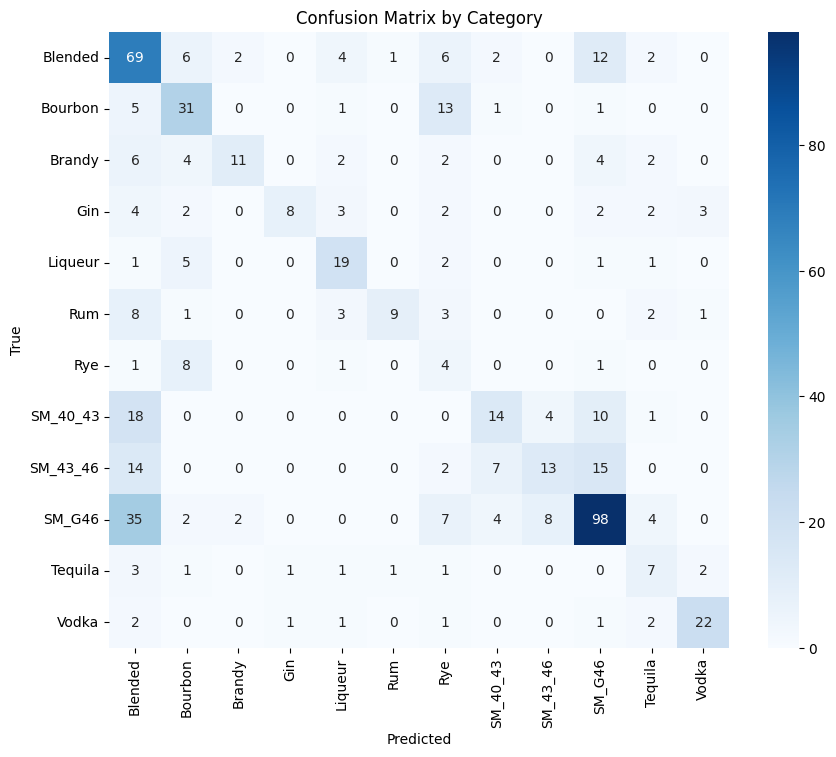

In [38]:
from sklearn.metrics import classification_report, confusion_matrix

# 예측
y_pred = np.argmax(model.predict(test_images), axis=1)

# 클래스별 정확도, 정밀도, 재현율, F1 점수 출력
report = classification_report(
    test_labels,
    y_pred,
    target_names=le.classes_,
    digits=3
)
print(report)

# (선택) 혼동 행렬 시각화
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix by Category")
plt.show()